
# 🌾 Enriquecimiento Semántico y Visualización (Explicado Paso a Paso)

Este notebook es una versión **comentada y educativa** del proceso de enriquecimiento de un Grafo de Conocimiento de Agricultura de Precisión.

**Objetivo:**
Conectar nuestro grafo local (generado a partir de papers) con la nube de datos enlazados (LOD), específicamente **DBpedia**, para:
1.  **Identificar** entidades en los textos (Entity Linking).
2.  **Traer** información nueva sobre esas entidades (Enrichment).
3.  **Analizar** el resultado con consultas complejas y visualizaciones.

---



## Fase 0: Configuración y Carga

Aquí importamos las librerías necesarias:
*   `rdflib`: Para manejar grafos RDF.
*   `SPARQLWrapper`: Para hacer consultas a DBpedia remotamente.
*   `pandas`, `matplotlib`, `seaborn`: Para manejo de datos y gráficas.
*   `requests`: Para hablar con la API de DBpedia Spotlight.

También configuramos las rutas para que el notebook funcione tanto en la carpeta `notebooks/` como en la raíz.


In [1]:

import pandas as pd  # Librería para manejo de DataFrames (tablas de datos similares a Excel)
import rdflib  # Librería principal de Python para trabajar con grafos RDF
from rdflib import Graph, Literal, URIRef, Namespace  # Clases básicas de RDF: Grafo, Literal (dato), URI (identificador), Namespace (prefijo)
from rdflib.namespace import RDF, RDFS, OWL, FOAF, DCTERMS  # Namespaces estándar predefinidos que usaremos
import requests  # Librería para hacer peticiones HTTP a APIs web (como la de DBpedia Spotlight)
import time  # Librería para controlar el tiempo (usaremos pausas para no saturar las APIs)
from SPARQLWrapper import SPARQLWrapper, JSON  # Cliente especializado para consultar endpoints SPARQL remotos
import matplotlib.pyplot as plt  # Librería base para crear gráficos
import seaborn as sns  # Librería de gráficos estadísticos que mejora la estética de matplotlib
import networkx as nx  # Librería para análisis y visualización de grafos (redes) y nodos
import zipfile  # Librería para crear y manipular archivos ZIP comprimidos
import os  # Librería para interactuar con el sistema operativo (rutas, archivos, directorios)
from tqdm import tqdm  # Librería para mostrar barras de progreso en bucles largos

# --- Configuración de Rutas Robustas ---
# Este bloque determina dinámicamente dónde estamos ejecutando el script
# para construir las rutas a los archivos correctamente.
import os
if os.path.exists("notebooks"):
    # Si existe la carpeta "notebooks", asumimos que estamos en la raíz del proyecto
    BASE_DIR = "notebooks"
elif os.path.exists("data") and os.path.exists("out"):
    # Si existen "data" y "out", asumimos que ya estamos DENTRO de "notebooks"
    BASE_DIR = "."
else:
    # Caso por defecto (fallback) si no reconocemos la estructura
    BASE_DIR = "."

# Construimos las rutas absolutas o relativas basadas en BASE_DIR
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")  # Carpeta donde están los datos procesados (CSVs)
OUT_DIR = os.path.join(BASE_DIR, "out")  # Carpeta de salida para guardar el grafo y las imágenes

# Definimos rutas específicas a archivos clave que usaremos
INPUT_TTL = os.path.join(OUT_DIR, "agri_graph_improved.ttl")  # Ruta del grafo RDF generado previamente
OUTPUT_TTL = os.path.join(OUT_DIR, "enriched_graph.ttl")  # Ruta donde guardaremos el grafo enriquecido final
PAPERS_CSV = os.path.join(DATA_DIR, "papers.csv")  # Ruta del CSV con metadatos de los papers
FIELDS_CSV = os.path.join(DATA_DIR, "fields.csv")  # Ruta del CSV con las palabras clave (keywords)

# --- Definición de Namespaces ---
# EX: Nuestro namespace personalizado para este proyecto de agricultura
EX = Namespace("http://example.org/agri#")
# DBO y DBR: Namespaces oficiales de DBpedia (Ontología y Recursos)
DBO = Namespace("http://dbpedia.org/ontology/")
DBR = Namespace("http://dbpedia.org/resource/")

# --- Carga del Grafo Inicial ---
print(f"Cargando grafo base desde: {os.path.abspath(INPUT_TTL)}")
# Verificamos que el archivo exista antes de intentar cargarlo para evitar errores feos
if not os.path.exists(INPUT_TTL):
    raise FileNotFoundError(f"No se encuentra el archivo: {INPUT_TTL}")

g = Graph()  # Instanciamos un nuevo objeto grafo vacío de RDFLib
g.parse(INPUT_TTL, format="turtle")  # Leemos y parseamos el archivo Turtle (.ttl) en memoria
print(f"Grafo inicial cargado: {len(g)} triples")  # Imprimimos la cantidad de hechos (triples) cargados

# --- Carga de Metadatos (CSVs) ---
print(f"Cargando metadatos para entity linking...")
papers_df = pd.read_csv(PAPERS_CSV)  # Cargamos el archivo papers.csv en un DataFrame de Pandas
fields_df = pd.read_csv(FIELDS_CSV)  # Cargamos el archivo fields.csv en un DataFrame de Pandas

# --- Limpieza de Datos ---
# Eliminamos filas que no tengan abstract o ID, ya que son inútiles para el análisis semántico
papers_df = papers_df.dropna(subset=['abstract', 'paperId'])
# Eliminamos filas donde el abstract sea solo espacios en blanco (vacío visualmente)
papers_df = papers_df[papers_df['abstract'].str.strip() != ""]
print(f"Papers listos para procesar: {len(papers_df)}")


Cargando grafo base desde: c:\Users\Usuario\Documents\Universidad\7mo Ciclo\InterOperabilidadYExplotDatos\Bim1InteroperabilidadDatos2B (2) - copia\Bim1InteroperabilidadDatos-main - copia (2) - copia\notebooks\out\agri_graph_improved.ttl
Grafo inicial cargado: 71815 triples
Cargando metadatos para entity linking...
Papers listos para procesar: 729


In [2]:

print("--- Iniciando Fase A: Entity Linking (DBpedia Spotlight) ---")

# URL de la API pública de DBpedia Spotlight (servicio de anotación semántica)
SPOTLIGHT_API = "https://api.dbpedia-spotlight.org/en/annotate"
CONFIDENCE = 0.5  # Umbral de confianza: solo aceptamos entidades con score > 0.5 (falsos positivos vs negativos)
SUBSET_LIMIT = 50 # PROCESAMIENTO PARCIAL: Solo procesamos los primeros 50 papers para demostración rápida y no bloquear la API

# --- Paso 1: Enlazar Texto de Papers con Entidades ---
count = 0
# iterrows() nos permite recorrer el DataFrame fila por fila.
# tqdm() envuelve el iterador para mostrarnos una barra de progreso visual en la consola/notebook.
for index, row in tqdm(papers_df.head(SUBSET_LIMIT).iterrows(), total=SUBSET_LIMIT, desc="Annotating Papers"):
    abstract = row['abstract']  # Extraemos el texto del abstract para analizar
    paper_id = row['paperId']   # Extraemos el ID del paper para construir su URI
    
    # Reconstruimos la URI del paper tal como existe en nuestro grafo RDF usando f-string.
    # Debe coincidir exactamente con el patrón usado en generate_rdf.py (ej: http://example.org/agri#art-123)
    paper_uri = URIRef(f"{EX}art-{str(paper_id)}")
    
    try:
        # Preparamos la petición HTTP.
        # Headers: Indicamos que queremos la respuesta en formato JSON (estructurada).
        headers = {'Accept': 'application/json'}
        # Data: Los parámetros obligatorios que espera la API (el texto y la confianza mínima).
        data = {'text': abstract, 'confidence': CONFIDENCE}
        
        # Realizamos una petición POST. Usamos POST en lugar de GET porque los abstracts 
        # pueden ser muy largos y exceder el límite de caracteres de una URL en una petición GET.
        response = requests.post(SPOTLIGHT_API, data=data, headers=headers, timeout=15)
        
        # Si la respuesta es exitosa (código HTTP 200 OK)
        if response.status_code == 200:
            res_json = response.json()  # Parseamos el JSON recibido a un diccionario Python
            
            # Verificamos si la API encontró 'Resources' (la lista de entidades detectadas)
            if 'Resources' in res_json:
                for res in res_json['Resources']:
                    # Extraemos la URI de DBpedia de la entidad encontrada (ej: http://dbpedia.org/resource/Machine_learning)
                    dbpedia_uri = URIRef(res['@URI'])
                    
                    # Creamos un nuevo triple RDF:
                    # Sujeto: Nuestro paper local (paper_uri)
                    # Predicado: schema:mentions ("menciona")
                    # Objeto: La entidad de DBpedia descubierta (dbpedia_uri)
                    g.add((paper_uri, URIRef("http://schema.org/mentions"), dbpedia_uri))
        
        # IMPORTANTE: Pausa de 0.5 segundos entre peticiones para no ser bloqueados por la API pública (Rate Limiting)
        time.sleep(0.5)
        
    except Exception as e:
        # Capturamos cualquier error de red o parsing y seguimos con el siguiente paper sin detener el script
        print(f"Error procesando paper {paper_id}: {e}")

# --- Paso 2: Enlazar Keywords con Entidades (owl:sameAs) ---
print("\nEnlazando Keywords (Fields)...")
# Iteramos sobre todas las keywords disponibles en fields_df
for index, row in tqdm(fields_df.iterrows(), total=len(fields_df), desc="Linking Fields"):
    field_name = row['fieldName']  # La keyword (ej: "Artificial Intelligence")
    
    try:
        # Para keywords cortas usamos GET, es más rápido y el estándar para consultas simples.
        params = {'text': field_name, 'confidence': CONFIDENCE}
        headers = {'Accept': 'application/json'}
        response = requests.get(SPOTLIGHT_API, params=params, headers=headers, timeout=10)
        
        if response.status_code == 200:
            data = response.json()
            if 'Resources' in data:
                # Tomamos la primera coincidencia (la más probable según DBpedia)
                dbpedia_uri = URIRef(data['Resources'][0]['@URI'])
                
                # Buscamos en nuestro grafo local el nodo Concepto (skos:Concept) 
                # que tenga esta etiqueta exacta (field_name).
                query = f"""
                SELECT ?c WHERE {{
                    ?c a <http://www.w3.org/2004/02/skos/core#Concept> .
                    ?c <http://www.w3.org/2004/02/skos/core#prefLabel> "{field_name}" .
                }}
                """
                res = g.query(query) # Ejecutamos la búsqueda local
                
                # Si encontramos el concepto local, le añadimos un link 'owl:sameAs'
                # Esto significa: "Nuestro concepto local X es semánticamente idéntico al recurso Y de DBpedia"
                for r in res:
                    g.add((r.c, OWL.sameAs, dbpedia_uri))
        
        time.sleep(0.2) # Pausa breve de cortesía
    except Exception as e:
        print(f"Error linking field {field_name}: {e}")

# Mostramos el tamaño del grafo tras añadir todos los nuevos enlaces
print(f"Grafo después del entity linking: {len(g)} triples")


--- Iniciando Fase A: Entity Linking (DBpedia Spotlight) ---


Annotating Papers: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]



Enlazando Keywords (Fields)...


Linking Fields: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]

Grafo después del entity linking: 72448 triples


In [3]:

print("--- Iniciando Fase B: Enriquecimiento Semántico (SPARQL Federation) ---")

# --- Paso 1: Recolectar todas las URIs externas ---
dbpedia_uris = set() # Usamos un set (conjunto) para evitar duplicados automáticamente
# Buscamos todas las URIs que son objeto de 'schema:mentions' y pertenecen al dominio dbpedia.org
for o in g.objects(None, URIRef("http://schema.org/mentions")):
    if "dbpedia.org/resource" in str(o):
        dbpedia_uris.add(o)
# Buscamos todas las URIs que son objeto de 'owl:sameAs' y pertenecen al dominio dbpedia.org
for o in g.objects(None, OWL.sameAs):
    if "dbpedia.org/resource" in str(o):
        dbpedia_uris.add(o)

print(f"Total de entidades únicas a enriquecer encontradas: {len(dbpedia_uris)}")

# --- Paso 2: Configurar Cliente SPARQL ---
# Inicializamos el wrapper apuntando al endpoint oficial y público de DBpedia
sparql = SPARQLWrapper("http://dbpedia.org/sparql")
uris_list = list(dbpedia_uris) # Convertimos el set a lista para poder indexar y dividir
BATCH_SIZE = 50 # Consultaremos de 50 en 50 para no hacer una query gigante que falle por timeout

# --- Paso 3: Iterar y Consultar ---
# range(start, stop, step) nos permite saltar de 50 en 50 índices
for i in tqdm(range(0, len(uris_list), BATCH_SIZE), desc="Enriching Batches"):
    batch = uris_list[i:i+BATCH_SIZE] # Seleccionamos el subgrupo (lote) actual de URIs
    
    # Construimos la cláusula VALUES de SPARQL dinámicamente. 
    # Esto inyecta las 50 URIs directamente en la consulta como una tabla temporal.
    # Formato resultante: <uri1> <uri2> ...
    values_clause = " ".join([f"<{u}>" for u in batch])
    
    # Construimos la consulta SPARQL Federada
    # Pedimos: Nombre (foaf:name), Tema (dct:subject) y Resumen (dbo:abstract)
    # Usamos OPTIONAL para traer lo que exista, sin fallar si a una entidad le falta algún dato.
    query = f"""
    PREFIX foaf: <http://xmlns.com/foaf/0.1/>
    PREFIX dct: <http://purl.org/dc/terms/>
    PREFIX dbo: <http://dbpedia.org/ontology/>
    
    SELECT ?res ?name ?subject ?abstract WHERE {{
        VALUES ?res {{ {values_clause} }}
        OPTIONAL {{ ?res foaf:name ?name . }}
        OPTIONAL {{ ?res dct:subject ?subject . }}
        OPTIONAL {{ ?res dbo:abstract ?abstract . FILTER(LANG(?abstract) = "en") }} # Solo abstracts en inglés
    }}
    """
    
    try:
        # Configuramos y ejecutamos la query remota
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON) # Queremos JSON estructurado de vuelta
        results = sparql.query().convert() # Ejecutar y convertir a diccionario Python
        
        # Procesamos cada resultado devuelto por DBpedia
        for result in results["results"]["bindings"]:
            res_uri = URIRef(result["res"]["value"]) # La URI de la entidad (el sujeto)
            
            # Si vino el nombre, lo agregamos a nuestro grafo local con predicado foaf:name
            if "name" in result:
                g.add((res_uri, FOAF.name, Literal(result["name"]["value"])))
            
            # Si vino el tema (subject), lo agregamos como URI con predicado dct:subject
            if "subject" in result:
                g.add((res_uri, DCTERMS.subject, URIRef(result["subject"]["value"])))
            
            # Si vino el abstract, lo agregamos como Literal con idioma inglés
            if "abstract" in result:
                g.add((res_uri, DBO.abstract, Literal(result["abstract"]["value"], lang='en')))
                
    except Exception as e:
        # Si falla un lote (ej: timeout de DBpedia), lo reportamos y continuamos con el siguiente
        print(f"Error en el lote SPARQL (índice {i}): {e}")
        time.sleep(1) # Pausa de seguridad

# --- Paso 4: Guardar Resultado ---
# Serializamos el grafo completo (original + enriquecimientos) a disco en formato Turtle
g.serialize(destination=OUTPUT_TTL, format="turtle")
print(f"✅ Grafo Enriquecido guardado exitosamente en: {OUTPUT_TTL}")


--- Iniciando Fase B: Enriquecimiento Semántico (SPARQL Federation) ---
Total de entidades únicas a enriquecer encontradas: 479


Enriching Batches: 100%|██████████| 10/10 [01:14<00:00,  7.45s/it]


✅ Grafo Enriquecido guardado exitosamente en: .\out\enriched_graph.ttl


In [4]:

print("--- Fase C: Ejecutando Consultas SPARQL Analíticas ---")

# --- Consulta 1: Top Entidades Mencionadas ---
# Objetivo: Contar cuántas veces aparece cada URI mencionada en 'schema:mentions'
# Agrupamos por ?entity, contamos ?paper, ordenamos descendente y limitamos a 10.
q1 = """
PREFIX schema: <http://schema.org/>
SELECT ?entity (COUNT(?paper) as ?mentionCount) WHERE {
    ?paper schema:mentions ?entity .
} GROUP BY ?entity ORDER BY DESC(?mentionCount) LIMIT 10
"""
print("\n1. Top 10 Entidades Mencionadas (Output de consola):")
# Ejecutamos la query contra el grafo 'g'
for row in g.query(q1):
    # row.entity es la URI completa, usamos split('/')[-1] para ver solo el nombre final por limpieza
    print(f"{row.mentionCount} menciones - {row.entity.split('/')[-1]}")

# --- Consulta 2: Papers de Alto Impacto con Tópicos Enriquecidos ---
# Objetivo: Ver qué temas tratan los papers más citados.
# Usamos 'COALESCE' para robustez: si la entidad tiene nombre (traído de DBpedia), lo usa.
# Si no, usa la URI convertida a string. Esto evita celdas vacías si el enriquecimiento falló parcialmente.
q2 = """
PREFIX schema: <http://schema.org/>
PREFIX ex: <http://example.org/agri#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?title ?cites ?entityName WHERE {
    ?paper a schema:Article ;          # Es una instancia de Article
           schema:title ?title ;       # Tiene un título
           ex:citationCount ?cites ;   # Tiene conteo de citas
           schema:mentions ?entity .   # Menciona una entidad
    
    # Intentamos obtener el nombre enriquecido (OPTIONAL)
    OPTIONAL { ?entity foaf:name ?n }
    
    # Elegimos ?n si existe, sino STR(?entity) (URI como string)
    BIND(COALESCE(?n, STR(?entity)) AS ?entityName)
    
    FILTER(?cites > 0) # Solo mostramos papers que tengan al menos 1 cita
} ORDER BY DESC(?cites) LIMIT 5
"""
print("\n2. Papers de Impacto y sus Temas (Output de consola):")
for row in g.query(q2):
    print(f"[{row.cites}] {row.title[:40]}... -> {row.entityName}")

# --- Consulta 3: Red de Co-ocurrencia ---
# Objetivo: Encontrar pares de entidades que aparecen juntas en el mismo paper.
# Esto revela relaciones latentes entre conceptos (ej: si A y B aparecen mucho juntos, están relacionados).
q3 = """
PREFIX schema: <http://schema.org/>
SELECT ?e1 ?e2 (COUNT(?paper) as ?coCount) WHERE {
    ?paper schema:mentions ?e1 . # El paper P menciona entidad A (e1)
    ?paper schema:mentions ?e2 . # El MISMO paper P menciona entidad B (e2)
    
    # Filtro < evita que tengamos el par (A, B) y (B, A) duplicados y evita (A, A) consigo mismo
    FILTER(STR(?e1) < STR(?e2)) 
} GROUP BY ?e1 ?e2 ORDER BY DESC(?coCount) LIMIT 15
"""
print("\n3. Top Pares Co-ocurrentes (Output de consola):")
for row in g.query(q3):
    print(f"{row.coCount}: {row.e1.split('/')[-1]} <-> {row.e2.split('/')[-1]}")

# --- Consulta 4: Autores Polímatas (Diversidad) ---
# Objetivo: Ranking de autores por cantidad de temas DIFERENTES (DISTINCT) sobre los que escriben.
# Usa schema:author para llegar al autor y schema:name para su nombre.
q4 = """
PREFIX schema: <http://schema.org/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
SELECT ?authorName (COUNT(DISTINCT ?entity) as ?topicCount) WHERE {
    ?paper schema:author ?author .      # Paper tiene autor
    ?author schema:name ?authorName .   # Autor tiene nombre
    ?paper schema:mentions ?entity .    # Paper menciona tema
} GROUP BY ?authorName ORDER BY DESC(?topicCount) LIMIT 10
"""
print("\n4. Diversidad de Temas por Autor (Output de consola):")
for row in g.query(q4):
    print(f"{row.topicCount} temas únicos - {row.authorName}")

# --- Consulta 5: Validación de Keywords ---
# Objetivo: Verificar visualmente que los keywords locales (Concept) se conectaron a DBpedia correctamente.
q5 = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>
SELECT ?label ?dbpediaURI WHERE {
    ?c a skos:Concept ;
       skos:prefLabel ?label ; # Etiqueta local (ej: "Agriculture")
       owl:sameAs ?dbpediaURI . # URI remota enlazada (ej: dbpedia:Agriculture)
} LIMIT 5
"""
print("\n5. Ejemplo de Mapeo Keywords -> DBpedia (Output de consola):")
for row in g.query(q5):
    print(f"{row.label} -> {row.dbpediaURI}")


--- Fase C: Ejecutando Consultas SPARQL Analíticas ---

1. Top 10 Entidades Mencionadas (Output de consola):
25 menciones - Precision_agriculture
17 menciones - Agriculture
8 menciones - Remote_sensing
6 menciones - Wireless_sensor_network
6 menciones - Wireless
6 menciones - Unmanned_aerial_vehicle
5 menciones - Algorithm
4 menciones - Internet
4 menciones - Hyperspectral_imaging
4 menciones - Machine_learning

2. Papers de Impacto y sus Temas (Output de consola):
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Unmanned_aerial_vehicle
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Wireless
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Remote_sensing
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Precision_agriculture
[1729.0] Unmanned Aerial Vehicles: A Survey on Ci... -> http://dbpedia.org/resource/Smart_device

3. Top Pares Co-ocurrentes

--- Fase D: Generando Visualizaciones Gráficas ---


C:\Users\Usuario\AppData\Local\Temp\ipykernel_38316\33091662.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_viz, x="Count", y="Entity", palette="viridis") # Barplot horizontal


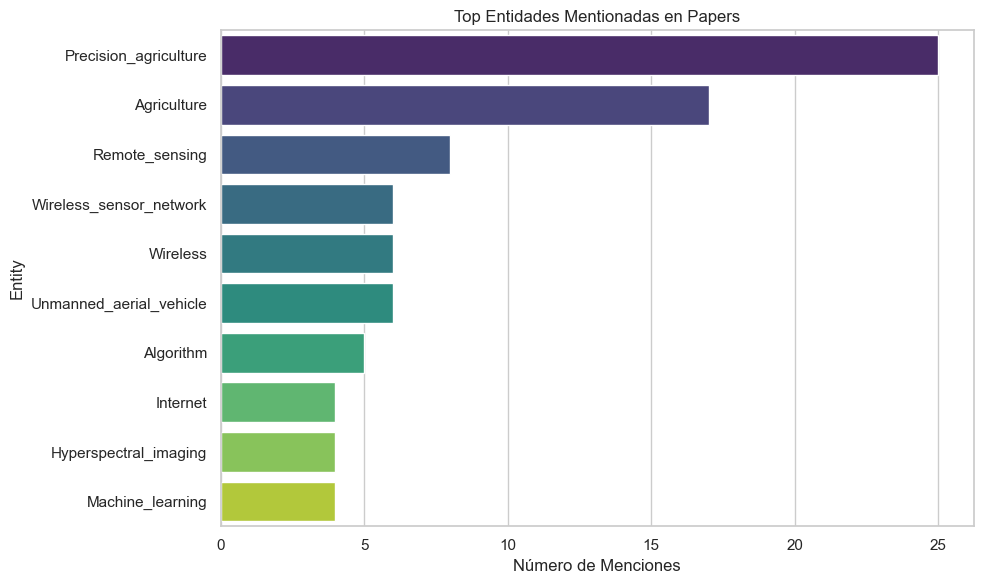

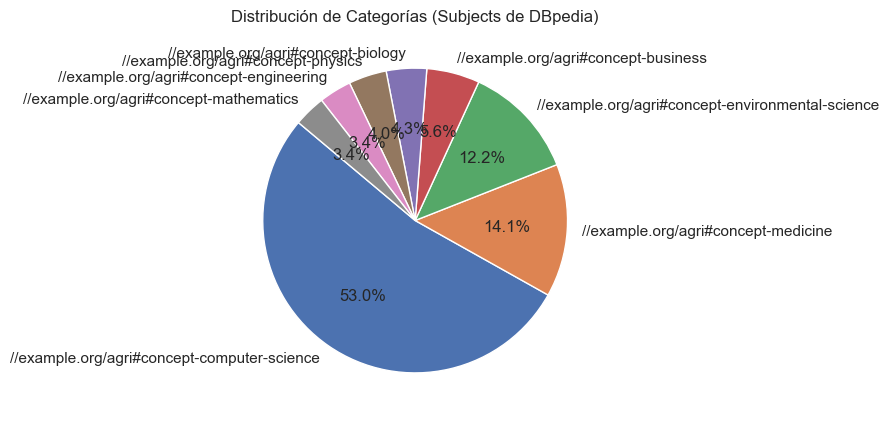

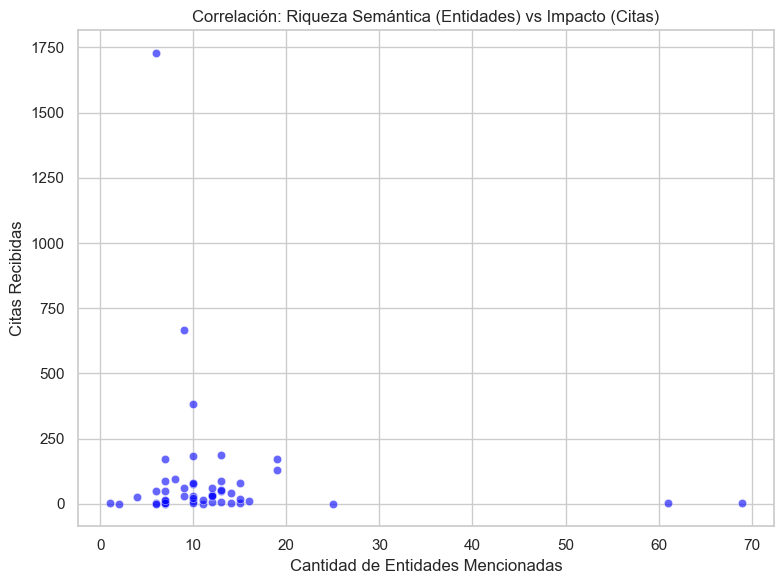

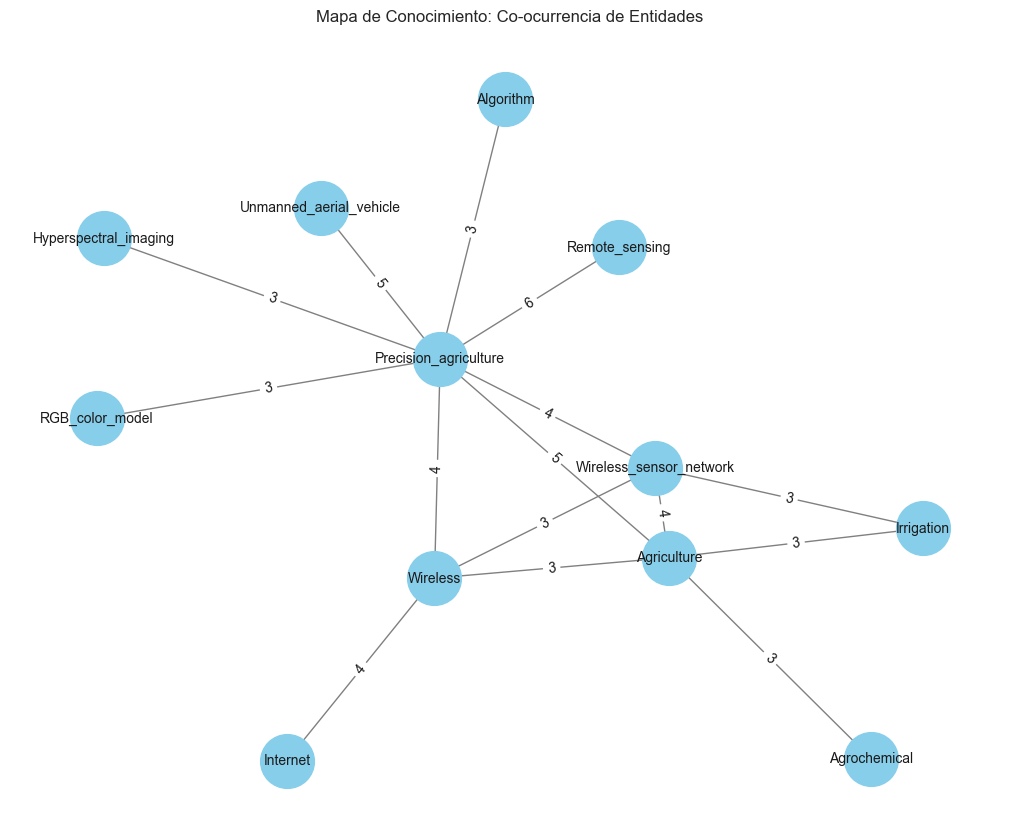

C:\Users\Usuario\AppData\Local\Temp\ipykernel_38316\33091662.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_auth, x="Topics", y="Author", palette="magma")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_38316\33091662.py:110: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Usuario\AppData\Local\Temp\ipykernel_38316\33091662.py:111: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  plt.savefig(os.path.join(OUT_DIR, "viz_authors.png"))
c:\Users\Usuario\Documents\Universidad\7mo Ciclo\InterOperabilidadYExplotDatos\Bim1InteroperabilidadDatos2B (2) - copia\Bim1InteroperabilidadDatos-main - copia (2) - copia\.venv_check\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io,

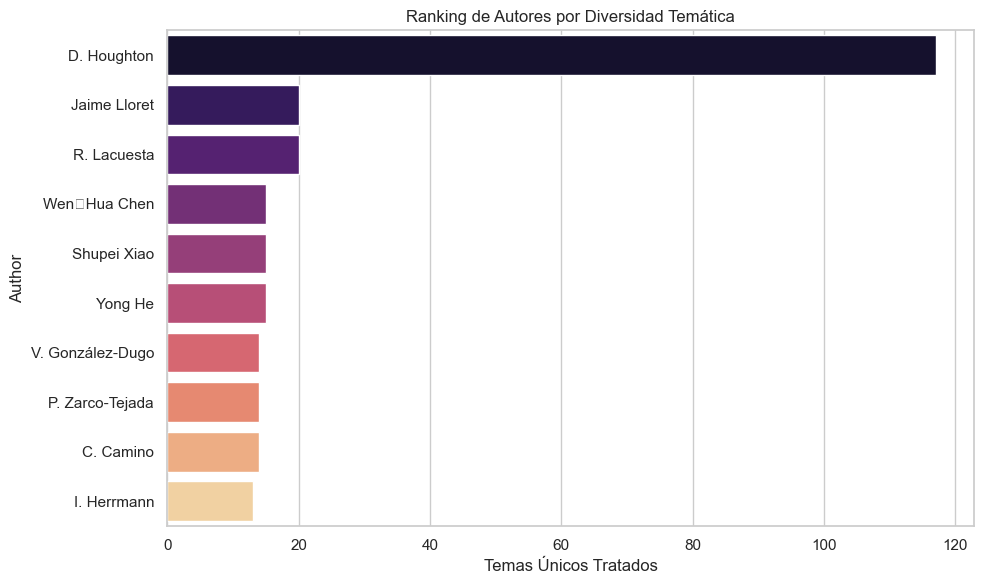

In [5]:

print("--- Fase D: Generando Visualizaciones Gráficas ---")
# Establecemos el estilo visual de seaborn (fondo blanco con grilla, más limpio)
sns.set_theme(style="whitegrid")

# --- VIZ 1: Gráfico de Barras (Top Entidades) ---
# Reutilizamos la Query 1 (q1) ya ejecutada en memoria (o ejecutamos de nuevo si queremos estar seguros)
res = g.query(q1)
data = []
# Procesamos los resultados de SPARQL a una lista de diccionarios Python
for row in res:
    data.append({
        "Entity": str(row.entity).split('/')[-1], # Limpiamos la URI para tener solo el nombre
        "Count": int(row.mentionCount)            # Convertimos el literal RDF a entero Python
    })
# Creamos un DataFrame de Pandas (formato tabular ideal para Seaborn)
df_viz = pd.DataFrame(data)

# Configuración del gráfico
plt.figure(figsize=(10, 6)) # Definimos el tamaño de la figura en pulgadas
sns.barplot(data=df_viz, x="Count", y="Entity", palette="viridis") # Barplot horizontal
plt.title("Top Entidades Mentionadas en Papers") # Título
plt.xlabel("Número de Menciones") # Etiqueta eje X
plt.tight_layout() # Ajuste automático de márgenes para que no se corten etiquetas
plt.savefig(os.path.join(OUT_DIR, "viz_top_entities.png")) # Guardar a archivo PNG
plt.show() # Mostrar en celda del notebook

# --- VIZ 2: Gráfico de Pastel (Top Categorías/Subjects) ---
# Hacemos una nueva query para contar por dct:subject
q_sub = """
PREFIX dct: <http://purl.org/dc/terms/>
SELECT ?subject (COUNT(?s) as ?subjCount) WHERE {
    ?s dct:subject ?subject .
} GROUP BY ?subject ORDER BY DESC(?subjCount) LIMIT 8
"""
res_sub = g.query(q_sub)
# List Comprehension para extraer etiquetas y valores limpiamente
labels = [str(r.subject).split(':')[-1] for r in res_sub]
sizes = [int(r.subjCount) for r in res_sub]

if sizes: # Verificamos que haya datos antes de graficar
    plt.figure(figsize=(8, 8)) # Gráfico cuadrado para el pastel
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140) # autopct muestra porcentajes
    plt.title("Distribución de Categorías (Subjects de DBpedia)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "viz_subjects_pie.png"))
    plt.show()

# --- VIZ 3: Scatter Plot (Citas vs Menciones) ---
# Queremos ver si existe correlación: ¿papers con más menciones a entidades reciben más citas?
q_scatter = """
PREFIX schema: <http://schema.org/>
PREFIX ex: <http://example.org/agri#>
SELECT ?paper (SAMPLE(?cites) as ?citationCount) (COUNT(?entity) as ?mentionCount) WHERE {
    ?paper a schema:Article ;
           ex:citationCount ?cites ;
           schema:mentions ?entity .
} GROUP BY ?paper LIMIT 100
"""
res_scatter = g.query(q_scatter)
# CRÍTICO: Convertimos citationCount a float() porque puede venir como decimal RDF ("10.0")
# y el constructor int() de Python fallaría con strings decimales.
data_scatter = [
    {"Cites": float(r.citationCount), "Mentions": int(r.mentionCount)} 
    for r in res_scatter
]
df_scatter = pd.DataFrame(data_scatter)

plt.figure(figsize=(8, 6))
# Usamos scatterplot para puntos XY
sns.scatterplot(data=df_scatter, x="Mentions", y="Cites", color="blue", alpha=0.6)
plt.title("Correlación: Riqueza Semántica (Entidades) vs Impacto (Citas)")
plt.xlabel("Cantidad de Entidades Mencionadas")
plt.ylabel("Citas Recibidas")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_scatter.png"))
plt.show()

# --- VIZ 4: Grafo de Red (Co-ocurrencia) ---
# Usamos NetworkX para visualizar la red de conceptos
res_q3 = g.query(q3) # Reutilizamos Q3 (pares e1, e2, count)
G = nx.Graph() # Grafo vacío de NetworkX

for row in res_q3:
    e1 = str(row.e1).split('/')[-1]
    e2 = str(row.e2).split('/')[-1]
    w = int(row.coCount) # Peso de la arista = frecuencia conjunta
    G.add_edge(e1, e2, weight=w) # Añadimos arista entre e1 y e2 con peso w

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.5) # Algoritmo de distribución de nodos (fuerza, k regula separación)
# Dibujamos nodos y aristas
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, edge_color='gray')
# Dibujamos las etiquetas de peso (números) sobre las aristas
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Mapa de Conocimiento: Co-ocurrencia de Entidades")
plt.savefig(os.path.join(OUT_DIR, "viz_network.png"))
plt.show()

# --- VIZ 5: Barras Horizontal (Autores) ---
res_q4 = g.query(q4) # Reutilizamos Q4 (Autor, TopicCount)
data_auth = [{"Author": str(r.authorName), "Topics": int(r.topicCount)} for r in res_q4]
df_auth = pd.DataFrame(data_auth)

plt.figure(figsize=(10, 6))
# Gráfico horizontal (x=Topics, y=Author) facilita leer nombres largos de autores
sns.barplot(data=df_auth, x="Topics", y="Author", palette="magma")
plt.title("Ranking de Autores por Diversidad Temática")
plt.xlabel("Temas Únicos Tratados")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "viz_authors.png"))
plt.show()


In [6]:

print("--- Fase E: Empaquetado Final del Entregable ---")

# Lista de todos los archivos que queremos incluir en el ZIP final
files_to_zip = [
    PAPERS_CSV, # Datos crudos: papers
    FIELDS_CSV, # Datos crudos: keywords
    INPUT_TTL,  # Grafo original (sin enriquecer)
    OUTPUT_TTL, # Grafo enriquecido (Resultado final de fase B)
    os.path.join(OUT_DIR, "viz_top_entities.png"), # Imagen 1
    os.path.join(OUT_DIR, "viz_subjects_pie.png"), # Imagen 2
    os.path.join(OUT_DIR, "viz_scatter.png"),      # Imagen 3
    os.path.join(OUT_DIR, "viz_network.png"),      # Imagen 4
    os.path.join(OUT_DIR, "viz_authors.png"),      # Imagen 5
    "Enrichment_and_Viz_commented.ipynb"           # IMPORTANTE: Incluimos este mismo notebook
]

ZIP_NAME = "Entregable_Final.zip"
zip_path = os.path.join(OUT_DIR, ZIP_NAME)

# Usamos la librería zipfile para escribir el archivo comprimido
with zipfile.ZipFile(zip_path, 'w') as zf:
    for f in files_to_zip:
        if os.path.exists(f):
            # Escribimos el archivo en el zip, usando solo su nombre base 
            # (arcname=os.path.basename(f)) para evitar crear carpetas anidadas dentro del zip
            zf.write(f, os.path.basename(f))
        else:
            print(f"⚠️ Aviso: Archivo {f} no encontrado, se omitirá del ZIP.")

print(f"✅ ZIP Final Generado Exitosamente: {zip_path}")


--- Fase E: Empaquetado Final del Entregable ---
✅ ZIP Final Generado Exitosamente: .\out\Entregable_Final.zip
